In [2]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import  PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, explained_variance_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# linear regressions
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, Ridge

# non-linear regressions
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import src.wrangle as wr

############## GLOBAL VARIABLES ###########
seed = 2912 # random seed for random_states

# load shelter data
df = wr.get_shelter_data()
# create dummies for categorical variables
df = wr.dummies(df)
# drop unneeded columns
df.drop(columns=['age_in_days', 'times_in_shelter', 'mixed_breed', 'domestic_breed', 'pitbull', 'outcome_type'], 
        inplace=True)

# split the data
train_validate, test = train_test_split(df, test_size=0.2, 
                                        random_state=seed)
train, validate = train_test_split(train_validate, test_size=0.3, 
                                   random_state=seed)

X_train = train.iloc[:, :-1].copy()
X_validate = validate.iloc[:, :-1].copy()
X_test = test.iloc[:, :-1].copy()
# scale age_on_check_in columns with the standard scaler
scaler = StandardScaler()
X_train[['age_on_check_in']] = scaler.fit_transform(X_train[['age_on_check_in']])
X_validate[['age_on_check_in']] = scaler.transform(X_validate[['age_on_check_in']])
X_test[['age_on_check_in']] = scaler.transform(X_test[['age_on_check_in']])
# target variable for train, validate and test sets
y_train = train.iloc[:, -1:].copy()
y_validate = validate.iloc[:, -1:].copy()
y_test = test.iloc[:, -1:].copy()

# baseline 65.729545164 days
baseline = y_train.mean()[0]

In [3]:
baseline

65.72954516405865

In [4]:
predictions_train = y_train.copy()
predictions_validate = y_validate.copy()
predictions_train['baseline'] = baseline
predictions_validate['baseline'] = baseline

In [11]:
parameters = {'max_depth'         : [4,6,8],
              'max_features' : [3, 4, 5],
              'min_samples_leaf'    : [1, 2, 3]
             }

In [12]:
from sklearn.model_selection import GridSearchCV

In [15]:
rf = RandomForestRegressor(random_state=seed)
grid = GridSearchCV(estimator=rf, param_grid=parameters, cv=2, n_jobs=-1)

In [23]:
y = y_train.values.reshape(len(y_train))

In [29]:
y_val = y_validate.values.reshape(len(y_validate))

In [24]:
grid.fit(X_train, y)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=2912),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 3]})

In [25]:
grid.best_params_

{'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 3}

In [27]:
# DataFrame to keep model's evaluations
scores = pd.DataFrame(columns=['model_name', 'RMSE_train', 'R2_train', 'RMSE_validate', 
                               'R2_validate', 'RMSE_difference'])

# create a dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Generalized Linear Model': TweedieRegressor(power=2, alpha = 0.5),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=seed),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=8, max_features=5, min_samples_leaf=3, random_state=seed),
    'Random Forest Regression':RandomForestRegressor(max_depth=8, max_features=5, min_samples_leaf=3, random_state=seed),
    'LassoLars Regression':LassoLars(alpha=0.1)
    }

In [28]:
def regression_errors(y_actual:pd.Series, y_predicted:pd.Series):
    '''
    this function accepts 
    y: actual results/array
    yhat: predictions/array
    k: feature size/integer
    calculates regression scores based on the baseline being median
    returns RMSE and adjacted R2
    '''
    # root mean squared error score
    RMSE = mean_squared_error(y_actual, y_predicted) ** .5
    # adjucted R^2 score
    ADJR2 = explained_variance_score(y_actual, y_predicted)
    return round(RMSE), round(ADJR2, 2)

In [7]:
y_train.values.ravel()

array([ 6, 57,  5, ..., 71, 11,  6])

In [30]:
for key in models:
    # create a model
    model = models[key]
    # fit the model
    model.fit(X_train, y)
    # predictions of the train set
    y_hat_train = model.predict(X_train)
    # predictions of the validate set
    y_hat_validate = model.predict(X_validate)
    # add train set predictions to the data frame
    predictions_train[key] = y_hat_train
    # add validate set predictions to the data frame
    predictions_validate[key] = y_hat_validate

    # calculate scores train set
    RMSE, R2 = regression_errors(y_train, y_hat_train)
    # calculate scores validation set
    RMSE_val, R2_val = regression_errors(y_validate, y_hat_validate)
    diff = np.abs(RMSE - RMSE_val)

    # add the score results to the scores Data Frame
    scores.loc[len(scores.index)] = [key, RMSE, R2, RMSE_val, R2_val, diff]

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [31]:
scores

,model_name,RMSE_train,R2_train,RMSE_validate,R2_validate,RMSE_difference
0,Linear Regression,207,0.02,199,0.02,8
1,Generalized Linear Model,207,0.01,199,0.01,8
2,Gradient Boosting Regression,204,0.05,198,0.03,6
3,Decision Tree Regression,206,0.03,199,0.02,7
4,Random Forest Regression,205,0.03,198,0.03,7
5,LassoLars Regression,209,0.00,201,0.00,8


In [32]:
RMSE_baseline, _ = regression_errors(y_train, predictions_train['baseline'])

In [33]:
RMSE_baseline

209

Using XBoost

In [11]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [13]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 9, alpha = 10, n_estimators = 10, random_state=seed)

In [14]:
xg_reg

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [69]:
xg_reg.fit(X_train,y_train)

predictions_train['xboost'] = xg_reg.predict(X_train)
predictions_validate['xboost'] = xg_reg.predict(X_validate)
RMSE, R2 = regression_errors(y_train, predictions_train['xboost'])
RMSE_val, R2_val = regression_errors(y_validate, predictions_validate['xboost'])

In [65]:
scores.loc[len(scores.index)] = ['xboost', RMSE, R2, RMSE_val, R2_val, np.abs(RMSE - RMSE_val)]

In [70]:
scores

,model_name,RMSE_train,R2_train,RMSE_validate,R2_validate,RMSE_difference
0,Linear Regression,207,0.02,199,0.02,8
1,Generalized Linear Model,207,0.01,199,0.01,8
2,Gradient Boosting Regression,204,0.05,198,0.03,6
3,Decision Tree Regression,202,0.06,200,0.01,2
4,Random Forest Regression,200,0.08,198,0.02,2
5,LassoLars Regression,209,0.00,201,0.00,8
6,xboost,208,0.02,200,0.02,8
7,xboost,206,0.03,200,0.02,6


Cross Validation

In [73]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=10,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=seed)

In [74]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,216.412724,0.751989,216.412946,1.547365
1,214.645984,0.653727,214.666007,1.607458
2,213.152936,0.778213,213.217121,1.483278
3,211.910046,0.763406,212.001631,1.459918
4,210.805956,0.874056,210.978982,1.373945
5,209.944468,0.979937,210.188448,1.334245
6,209.266064,0.928816,209.531559,1.364966
7,208.711648,0.849016,208.994859,1.426287
8,208.199038,0.808358,208.521026,1.430801
9,207.750048,0.706129,208.125624,1.486516


Feature importance

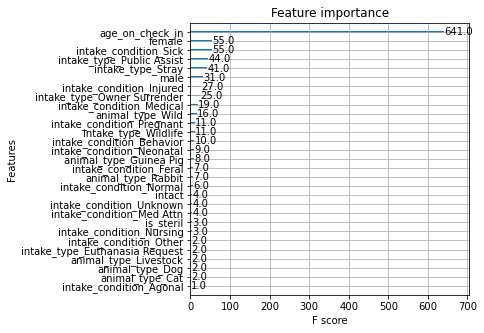

In [78]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 7]
plt.show()

Cat Boost

In [80]:
from catboost import CatBoostRegressor

In [82]:
cbr = CatBoostRegressor()

In [1]:
cbr?

Object `cbr` not found.


In [83]:
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
             }